**Data Challenge 2022:**


**Brazilian Dataset**

The dataset is a test dataset provided by Olist Store, an ecommerce store.
The dataset contains:



100 k orders and order view from multiple dimensions: 
order status,
price,
payment,
customer location,
product attributes,
reviews written by customer,
geolocation dataset that relates Brazilian zip codes to lat/lng coordinates
and order has one or many order items

**Data Loading**

Connecting this notebook with Google drive.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Installing all the necessary dependencies.

In [5]:
!apt install proj-bin libproj-dev libgeos-dev 
!apt-get install libgeos-3.5.0
!pip install https://github.com/matplotlib/basemap/archive/v1.1.0.tar.gz
!pip install basemap
!pip install pyproj==1.9.6
!pip install fasttext
!python -m spacy download pt
!pip install tensorflow_addons

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libgeos-dev set to manually installed.
libproj-dev is already the newest version (4.9.3-2).
libproj-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  cuda-command-line-tools-10-0 cuda-command-line-tools-10-1
  cuda-command-line-tools-11-0 cuda-compiler-10-0 cuda-compiler-10-1
  cuda-compiler-11-0 cuda-cuobjdump-10-0 cuda-cuobjdump-10-1
  cuda-cuobjdump-11-0 cuda-cupti-10-0 cuda-cupti-10-1 cuda-cupti-11-0
  cuda-cupti-dev-11-0 cuda-documentation-10-0 cuda-documentation-10-1
  cuda-documentation-11-0 cuda-documentation-11-1 cuda-gdb-10-0 cuda-gdb-10-1
  cuda-gdb-11-0 cuda-gpu-library-advisor-10-0 cuda-gpu-library-advisor-10-1
  cuda-libraries-10-0 cuda-libraries-10-1 cuda-libraries-11-0
  cuda-memcheck-10-0 cuda-memcheck-10-1 cuda-memcheck-11-0 cuda-nsight-10-0
  cuda-nsigh

     |████████████████████████████████| 2.8 MB 4.2 MB/s 
  Created wheel for pyproj: filename=pyproj-1.9.6-cp37-cp37m-linux_x86_64.whl size=3702462 sha256=8779ae5f1f08f9a0d3d81232f9918b13c965e70bdda53c026ef3fcaa6e1c3615
  Stored in directory: /root/.cache/pip/wheels/08/60/55/38382877bab48a6abfca7bd66115e287ce5a9530cbce631771
Successfully built pyproj
  Attempting uninstall: pyproj
    Found existing installation: pyproj 3.2.1
    Uninstalling pyproj-3.2.1:
      Successfully uninstalled pyproj-3.2.1
     |████████████████████████████████| 68 kB 2.9 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3138031 sha256=6ed2126691e4870ab3a1bea344d6260c8db77e62ad03b02baeb687b04aa65f21
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext
     |████████████████████████████████| 21.2 MB 503 kB/s 
  Created wheel for

Importing the required packages.

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import spacy
import regex as re
from datetime import datetime
from tqdm import tqdm
import pickle
import scipy

#for ML analysis:
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, log_loss
import fasttext.util
import warnings
from tensorflow_addons.metrics import F1Score
from sklearn.utils.extmath import randomized_svd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout, Embedding, LSTM, Flatten, Concatenate, Reshape, Conv1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.regularizers import l2
from xgboost import XGBClassifier
from prettytable import PrettyTable
from keras.models import load_model
from sklearn.metrics import plot_confusion_matrix


warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

Loading the data directly on Google Drive:

In [11]:
#from google.colab import files
#from datetime import datetime
#api_token = files.upload()

Loading all the CSV files onto RAM.

In [13]:
customers_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_customers_dataset.csv')
geolocation_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_geolocation_dataset.csv')
order_items_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_order_items_dataset.csv')
order_payments_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_order_payments_dataset.csv')
order_reviews_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_order_reviews_dataset.csv')
orders_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_orders_dataset.csv')
products_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_products_dataset.csv')
sellers_dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/olist_sellers_dataset.csv')
product_category_name_translation = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/product_category_name_translation.csv')

In [14]:
#customers_dataset = pd.read_csv('/content/olist_customers_dataset.csv')
#geolocation_dataset = pd.read_csv('/content/olist_geolocation_dataset.csv')
#order_items_dataset = pd.read_csv('/content/olist_order_items_dataset.csv')
#order_payments_dataset = pd.read_csv('/content/olist_order_payments_dataset.csv')
#order_reviews_dataset = pd.read_csv('/content/olist_order_reviews_dataset.csv')
#orders_dataset = pd.read_csv('/content/olist_orders_dataset.csv')
#products_dataset = pd.read_csv('/content/olist_products_dataset.csv')
#sellers_dataset = pd.read_csv('/content/olist_sellers_dataset.csv')
#product_category_name_translation = pd.read_csv('/content/product_category_name_translation.csv')

**Schematic diagram explaining the connectivity between these tables.**

All the tables in the database are connected to each other using primary and freign keys. We shall join all the individual CSV files to create a large table. All these keys end with the suffix 'id' or 'prefix'.

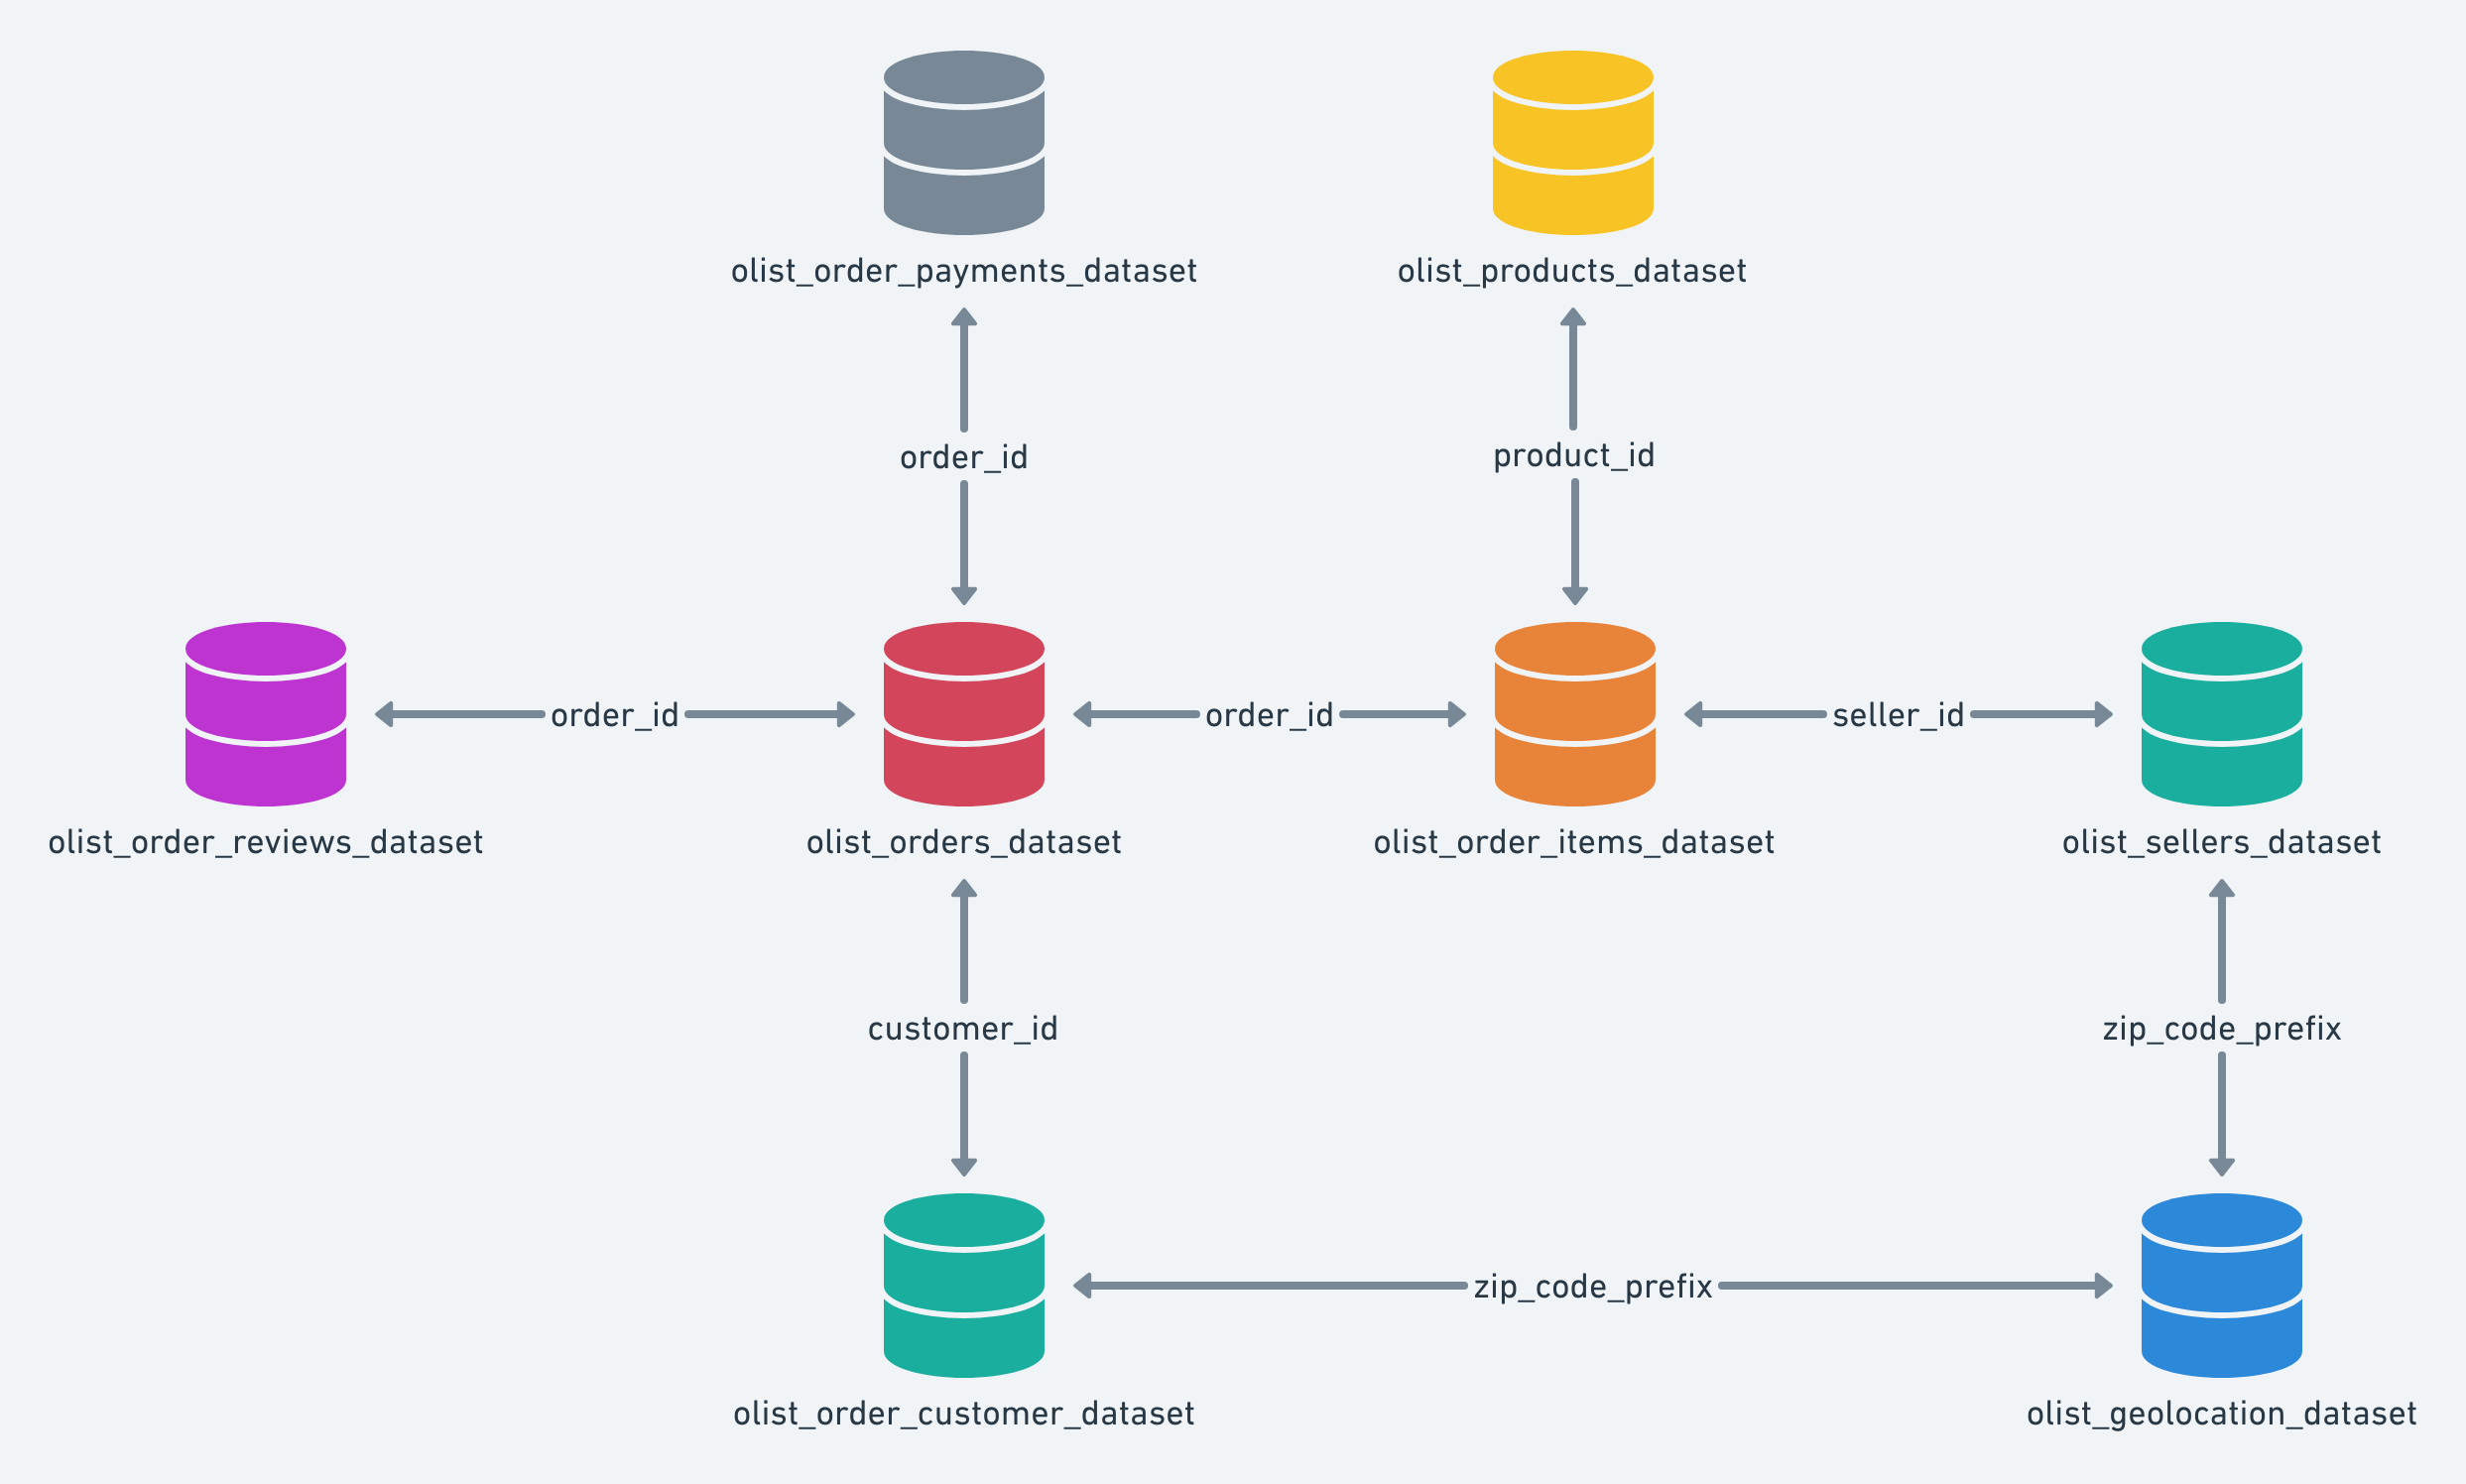

**ER Diagram:**

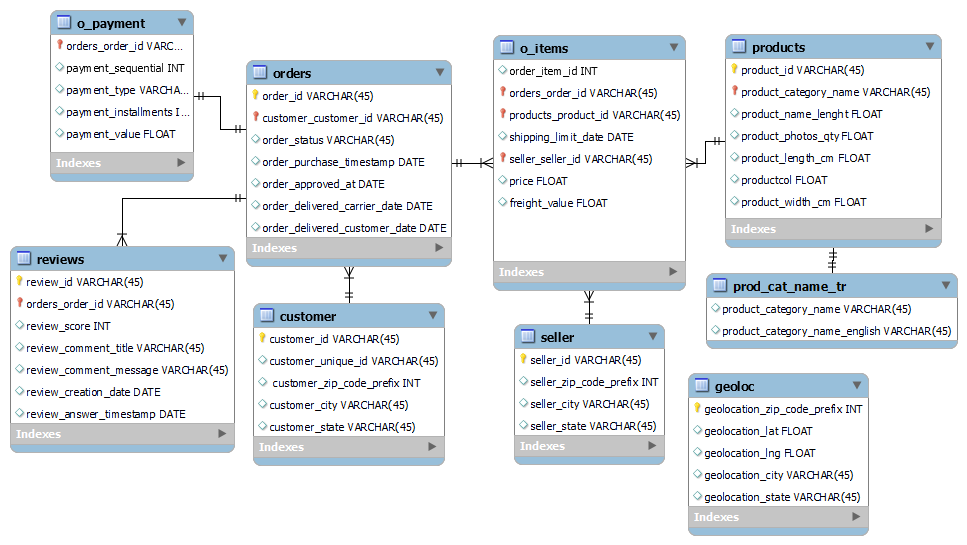

**Exploratory Data Analysis - EDA**


**Geolocation dataset that relates Brazilian zip codes to lat/lng coordinates:**

Since this dataset is based on a Brazilian e-commerce company, the area of circulation is most probably Brazil and its neighbouring countries. This is why we shall take the plot of the South American continent and use the geographical data mentioned in the geolocation dataset to visually depict the geographical locations of the orders.

In [15]:

from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
%matplotlib inline

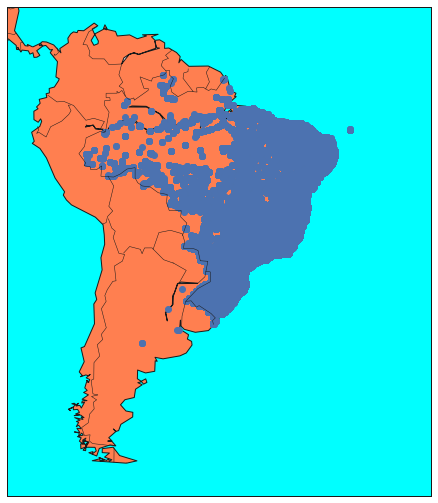

In [16]:
latitudes = geolocation_dataset['geolocation_lat'].values
longitudes = geolocation_dataset['geolocation_lng'].values

plt.figure(figsize=(14,9))
m = Basemap(llcrnrlat=-60,llcrnrlon=-85,urcrnrlat=15,urcrnrlon=-20)
m.drawcoastlines()
m.fillcontinents(color='coral')
m.scatter(longitudes,latitudes, zorder=2)
m.drawmapboundary(fill_color='aqua')
m.drawcountries()

plt.show()

For further analysis, we won't be using the geolocation dataset. This is why it won't be added to the main dataframe.

Create a main dataframe:

In [17]:
order_items_products = pd.merge(order_items_dataset,products_dataset,on='product_id')
order_items_products_sellers = pd.merge(order_items_products,sellers_dataset,on='seller_id')
two_order_items_products_sellers = pd.merge(order_items_products_sellers,orders_dataset,on='order_id')
two_order_items_products_sellers_customer = pd.merge(two_order_items_products_sellers,customers_dataset,on='customer_id')
two_order_items_products_sellers_customer_reviews = pd.merge(two_order_items_products_sellers_customer,order_reviews_dataset,on='order_id')
final_dataframe = pd.merge(two_order_items_products_sellers_customer_reviews,order_payments_dataset,on='order_id')

We are given an extra csv file named 'product categry name translation'. This file contains the English translations of the original Portuguese text. We shall replace the original product category names with these translations.

In [18]:
mapping = dict(zip(product_category_name_translation['product_category_name'].tolist(),product_category_name_translation['product_category_name_english'].tolist()))
final_dataframe['product_category_name'] = final_dataframe['product_category_name'].map(mapping)

In [19]:
final_dataframe.head(3)

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm,seller_zip_code_prefix,seller_city,seller_state,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp,payment_sequential,payment_type,payment_installments,payment_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.9,13.29,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,3ce436f183e68e07877b285a838db11a,delivered,2017-09-13 08:59:02,2017-09-13 09:45:35,2017-09-19 18:34:16,2017-09-20 23:43:48,2017-09-29 00:00:00,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,97ca439bc427b48bc1cd7177abe71365,5,NaN,"Perfeito, produto entregue antes do combinado.",2017-09-21 00:00:00,2017-09-22 10:57:03,1,credit_card,2,72.19
1,130898c0987d1801452a8ed92a670612,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-07-05 02:44:11,55.9,17.96,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,e6eecc5a77de221464d1c4eaff0a9b64,delivered,2017-06-28 11:52:20,2017-06-29 02:44:11,2017-07-05 12:00:33,2017-07-13 20:39:29,2017-07-26 00:00:00,0fb8e3eab2d3e79d92bb3fffbb97f188,75800,jatai,GO,b11cba360bbe71410c291b764753d37f,5,NaN,"lannister como sempre, entregou certinho e den...",2017-07-14 00:00:00,2017-07-17 12:50:07,1,boleto,1,73.86
2,532ed5e14e24ae1f0d735b91524b98b9,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2018-05-23 10:56:25,64.9,18.33,cool_stuff,58.0,598.0,4.0,650.0,28.0,9.0,14.0,27277,volta redonda,SP,4ef55bf80f711b372afebcb7c715344a,delivered,2018-05-18 10:25:53,2018-05-18 12:31:43,2018-05-23 14:05:00,2018-06-04 18:34:26,2018-06-07 00:00:00,3419052c8c6b45daf79c1e426f9e9bcb,30720,belo horizonte,MG,af01c4017c5ab46df6cc810e069e654a,4,super recomendo,carrinho muito bonito,2018-06-05 00:00:00,2018-06-06 21:41:12,1,credit_card,2,83.23


There are a few columns in this table which may not be necessary.

In [20]:
print(final_dataframe.columns)
final_dataframe.shape

Index(['order_id', 'order_item_id', 'product_id', 'seller_id',
       'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_unique_id',
       'customer_zip_code_prefix', 'customer_city', 'customer_state',
       'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value'],
      dtype='object')


(117329, 39)

Dropping all the duplicates which have the same Order ID, Customer ID, purchase timestamp, review message. This is becasue a customer cannot post the same review multiple times for the same product at the same instant of time.

In [21]:
final_dataframe = final_dataframe.drop_duplicates(subset=['order_id','order_purchase_timestamp','product_id','customer_unique_id','review_comment_message'])
final_dataframe.shape

(101878, 39)

All the ID values are unique. We are dropping these columns since they don't contribute much to understanding the data. We also cannot work with.

**Product Attributes:**

In [22]:
final_dataframe.drop(['order_id','product_id','seller_id','customer_unique_id'], axis=1, inplace=True)
final_dataframe.columns

Index(['order_item_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state', 'customer_id',
       'order_status', 'order_purchase_timestamp', 'order_approved_at',
       'order_delivered_carrier_date', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'customer_zip_code_prefix',
       'customer_city', 'customer_state', 'review_id', 'review_score',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_sequential',
       'payment_type', 'payment_installments', 'payment_value'],
      dtype='object')

For datetime data, we cannot work with null values. Dropping those rows which contain null values is needed.

In [23]:
final_dataframe.dropna(subset=['shipping_limit_date','order_purchase_timestamp','order_delivered_carrier_date','order_delivered_customer_date','order_estimated_delivery_date'], inplace=True)

We are parsing through some of the datetime columns and extracting the date information. The 'purchase delivery difference' gives us the number of days between the time of purchase and delivery. The 'estimated actual delivery difference' gives us the delay or the cut-down in the number of days actually required for the delivery.

In [24]:
intermediate_time = final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_purchase_timestamp'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['purchase-delivery difference'] = intermediate_time.apply(lambda x:x.days)

intermediate_time = final_dataframe['order_estimated_delivery_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date()) - final_dataframe['order_delivered_customer_date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S").date())
final_dataframe['estimated-actual delivery difference'] = intermediate_time.apply(lambda x:x.days)

**Data Clean:**

While moving onto the other types of columns, we shall find how many rows contains null values.

In [25]:
final_dataframe.isnull().sum()

order_item_id                               0
shipping_limit_date                         0
price                                       0
freight_value                               0
product_category_name                    1416
product_name_lenght                      1396
product_description_lenght               1396
product_photos_qty                       1396
product_weight_g                           16
product_length_cm                          16
product_height_cm                          16
product_width_cm                           16
seller_zip_code_prefix                      0
seller_city                                 0
seller_state                                0
customer_id                                 0
order_status                                0
order_purchase_timestamp                    0
order_approved_at                          14
order_delivered_carrier_date                0
order_delivered_customer_date               0
order_estimated_delivery_date     

After finding all the null values, we shall impute. For the categorical columns, we shall use the mode and for numerical columns we shall use the median for imputation. For revivew comments and title, we use the term 'indisponível' which is the Portuguese for unavailable.

In [26]:
final_dataframe['product_category_name'].fillna(value=final_dataframe['product_category_name'].mode()[0], inplace=True)
final_dataframe['product_name_lenght'].fillna(value=final_dataframe['product_name_lenght'].mode()[0], inplace=True)
final_dataframe['product_description_lenght'].fillna(value=final_dataframe['product_description_lenght'].median(), inplace=True)
final_dataframe['product_photos_qty'].fillna(value=final_dataframe['product_photos_qty'].mode()[0], inplace=True)
final_dataframe['product_weight_g'].fillna(value=final_dataframe['product_weight_g'].mode()[0], inplace=True)
final_dataframe['product_length_cm'].fillna(value=final_dataframe['product_length_cm'].mode()[0], inplace=True)
final_dataframe['product_height_cm'].fillna(value=final_dataframe['product_height_cm'].mode()[0], inplace=True)
final_dataframe['product_width_cm'].fillna(value=final_dataframe['product_width_cm'].mode()[0], inplace=True)
final_dataframe['review_comment_message'].fillna(value='indisponível', inplace=True)

**What is the order average review score? Reviews writing by customers: (negative/positive)**

It is possible to convert this problem into a multiclass classification task. For doing this, we shall convert all the review scores greater than 3 as part of the positive and the ones below 3 as part of the negative class. Reviews which have the value of 3 is considered to be part of the neutral class.

In [27]:
final_dataframe['review_score'] = final_dataframe['review_score'].apply(lambda x: 1 if x > 3 else 0)

In [28]:
final_dataframe['review_score'].unique()

array([1, 0])

On plotting the pie chart showing the review scores, we see that the positive class occupies 78.00% of the entire dataset; whereas the negative class only occupies 22.00%.

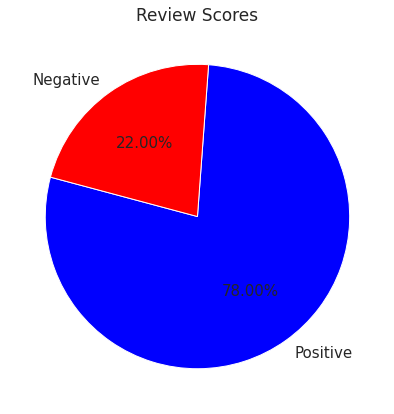

In [29]:
plt.figure(figsize=(7,7))
final_dataframe['review_score'].map({0:'Negative',1:'Positive'}).value_counts().plot.pie(autopct='%.2f%%', textprops={'fontsize':15}, startangle=165, colors=['blue','red','#f6b48f'])
plt.title('Review Scores', fontsize=17)
plt.ylabel('')
plt.show()

Some columns contain only numerical data. This means that finding the basic statistics of these columns is one thing which we can try. Notice that there is a significant difference between the mean and median values for the 'price' and 'product length description' columns.

In [30]:
final_dataframe[['price','freight_value','product_name_lenght','product_description_lenght','product_weight_g','product_length_cm', 'product_height_cm', 'product_width_cm']].describe().round(3)

,price,freight_value,product_name_lenght,product_description_lenght,product_weight_g,product_length_cm,product_height_cm,product_width_cm
count,99741.000,99741.000,99741.000,99741.000,99741.000,99741.000,99741.000,99741.000
mean,123.530,20.061,49.051,783.597,2082.759,30.062,16.357,23.024
std,186.164,15.763,9.977,645.221,3736.407,16.054,13.264,11.724
min,0.850,0.000,5.000,4.000,0.000,7.000,2.000,6.000
25%,40.000,13.140,43.000,348.000,300.000,18.000,8.000,15.000
50%,78.000,16.320,52.000,602.000,683.000,25.000,13.000,20.000
75%,139.000,21.180,57.000,980.000,1800.000,38.000,20.000,30.000
max,6735.000,409.680,76.000,3992.000,40425.000,105.000,105.000,118.000


Let us create a new column called 'price category' This column is used to categorize the goods as expensive, cheap and affordable based on their price. We have used the first, second and third quartiles as the conditions for creating these categories.

In [31]:
final_dataframe['price_category'] = final_dataframe['price'].apply(lambda x:'expensive' if x>=139 else ('affordable' if x>=40 and x<139 else 'cheap'))

**Total Orders:**

In [32]:
final_dataframe['price'].count()


99741

**Total Sales ($):**

In [33]:
final_dataframe['price'].sum().round(3)

12321014.17

**Which categories are most sold in quantity? Top most popular categories:**

We are now finding the top 12 most popular product categories in terms of the frequency of purchase. THe category 'bed bath table' significantly more popular than most of the other categories. It is the only category whose sales have crossed 10000 units. The category in the 12th position - 'garden tools' only had around 3500 units sold.

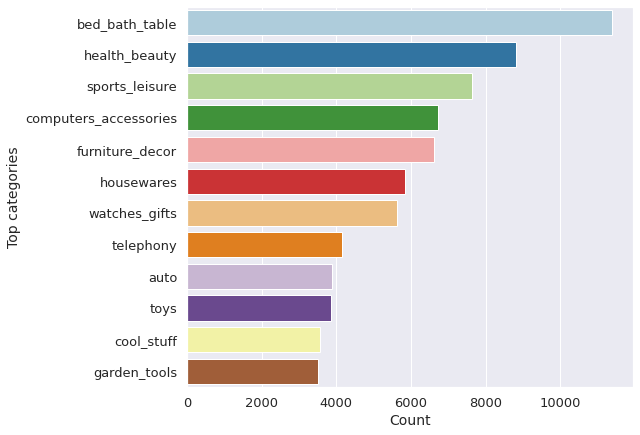

In [34]:
plt.figure(figsize=(8,7))
idx = final_dataframe['product_category_name'].value_counts()[:12].index
sns.countplot(y=final_dataframe['product_category_name'], order=idx, palette="Paired")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

**Which regions / cities pay more for transportation? Top Cities by price average:**

Sao Paulo, also shortened to 'SP' is by leaps and bounds the state with the highest customer base for this firm. It might be dur to the fact that this company's headquarters is set up in Sao Paulo and more customers were informed about this website due to their heavy marketing strategy around that area. More than 40000 units were sold in Sao Paulo between 2016 and 2018.

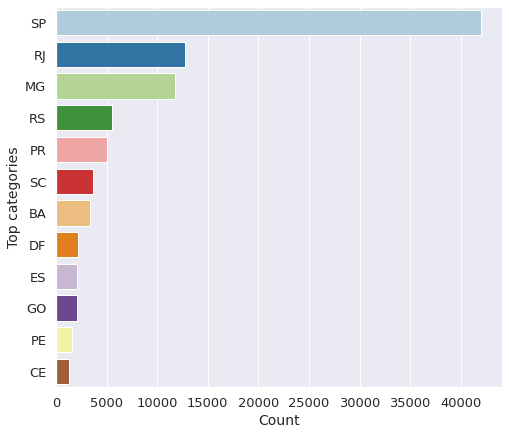

In [35]:
plt.figure(figsize=(8,7))
idx = final_dataframe['customer_state'].value_counts()[:12].index
sns.countplot(y=final_dataframe['customer_state'], order=idx, palette="Paired")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Count', fontsize=14)
plt.ylabel('Top categories', fontsize=14)
plt.show()

**Top Categories by price average:**

When we check the pricing per product category, we can see that the average cost of a product is the highest for the items belonging to the 'computers' category. The average cost is around 1500 real. The second highest category has an average price of nearly half of the highest category.

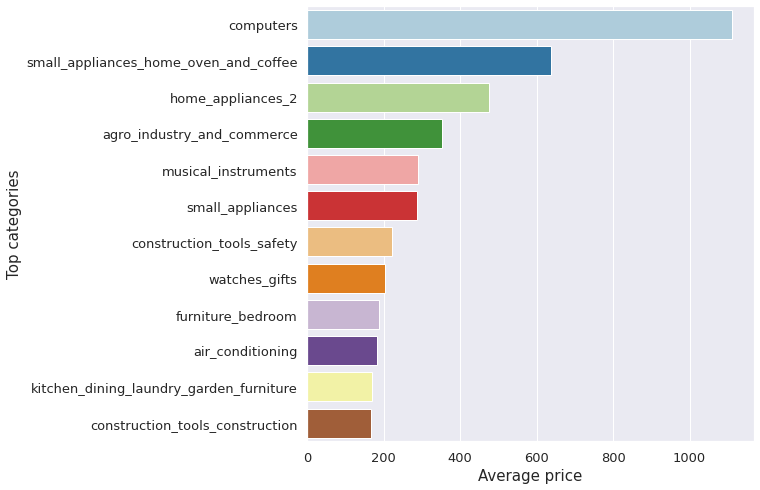

In [36]:
grp_cat_name = final_dataframe.groupby('product_category_name')
grp_dict = dict(grp_cat_name.mean()['price'].sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="Paired")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

**Average cost per item:**

For this plot, we considered the overall average cost of an item. This means that it is the sum of the fright charges and the original cost of the item. We can see that the ordering of the plot hasn't changed. It's only that the average cost of each category that has increased.

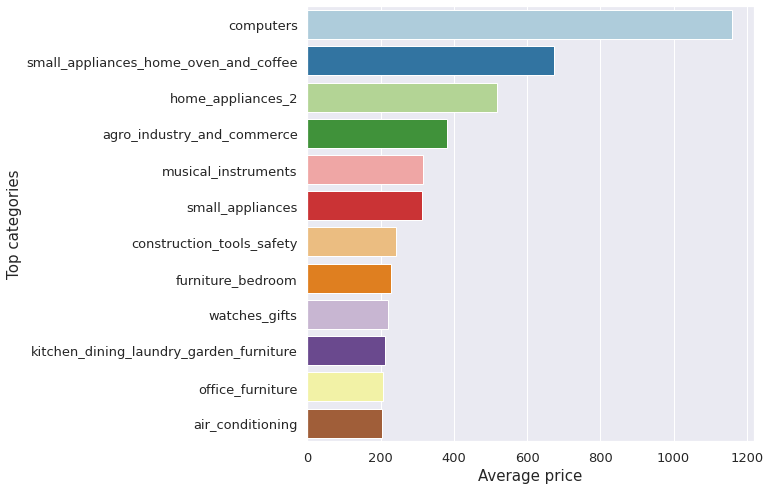

In [37]:
grp_dict = dict((grp_cat_name.mean()['price']+grp_cat_name.mean()['freight_value']).sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="Paired")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()

**Where does most revenue come from ? City with high revenue:** 

We are now finding the city which generates the highest revenue. The city named '**Pianco**' generates the highest revenue.

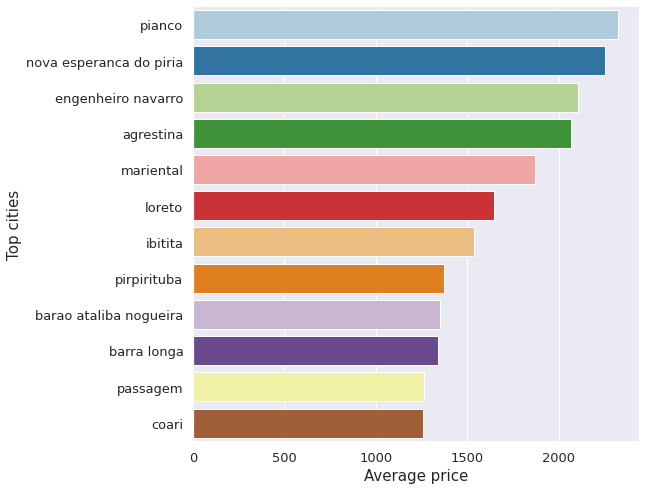

In [38]:
grp_state_name = final_dataframe.groupby('customer_city')
grp_dict = dict((grp_state_name.mean()['price']+grp_state_name.mean()['freight_value']).sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="Paired")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Average price', fontsize=15)
plt.ylabel('Top cities', fontsize=15)
plt.show()

**Order Status: (time taken for delivery)**

There are only two statuses visible here. Only 7 orders have been cancelled till date.

In [39]:
final_dataframe['order_status'].value_counts()

delivered    99734
canceled         7
Name: order_status, dtype: int64

It doesn't make sense to analyze those products which have been cancelled. Thus, we shall delete them.

In [40]:
final_dataframe = final_dataframe[final_dataframe['order_status'] != 'canceled']

**What is the average delivery time for orders? Average Delivery Time By Category:**

The office furniture is the most delayed category and the computers have the less delayed category.

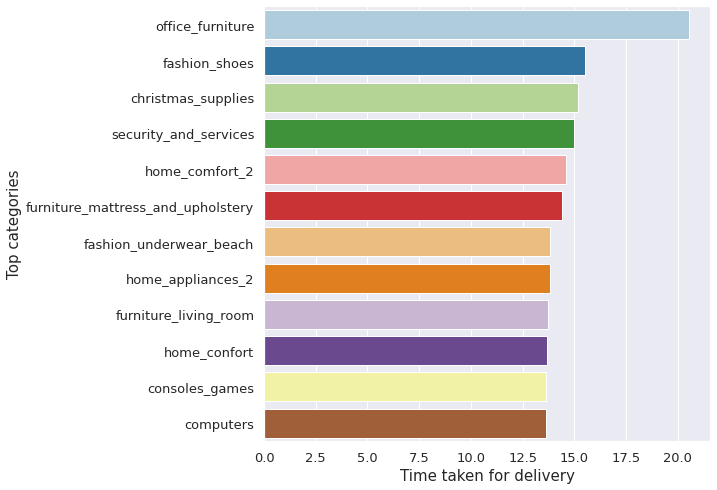

In [41]:
grp_cat_name = final_dataframe.groupby('product_category_name')
grp_dict = dict(grp_cat_name.mean()['purchase-delivery difference'].sort_values(ascending=False)[:12])
plt.figure(figsize=(8,8))
sns.barplot(y=list(grp_dict.keys()),x=list(grp_dict.values()), palette="Paired")
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.xlabel('Time taken for delivery', fontsize=15)
plt.ylabel('Top categories', fontsize=15)
plt.show()



**What is the percentage of delayed orders ? Price vs total time difference between delivery and purchase (related to score) :**

The below-given scatter plot takes the price on the x-axis and total time difference between delivery and purchase on the y-axis. It can be seen that as the time itaken for delivery increases, the chances to being dissatisfied with the product increases significantly. The increase in price of an item does not cause too much dissatisfaction if it is delivered on time.

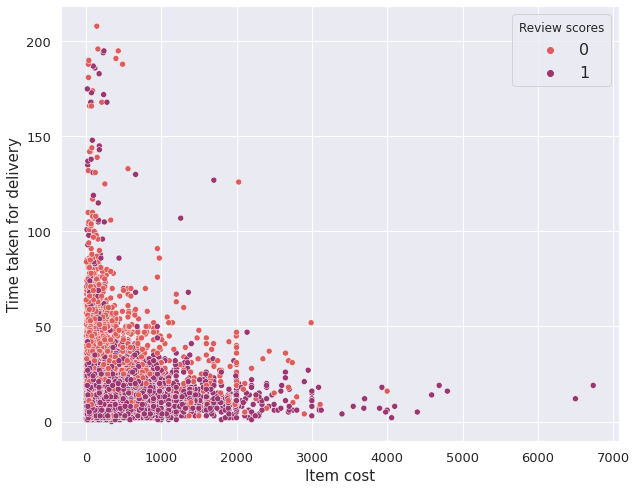

In [42]:
#Reference: https://stackoverflow.com/a/7125157

plt.figure(figsize=(10,8))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['purchase-delivery difference'],hue=final_dataframe['review_score'],palette="flare")
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('Time taken for delivery', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [43]:
final_dataframe['purchase_delivery_diff_per_price'] = final_dataframe['purchase-delivery difference']/final_dataframe['price']

**What is the product and freight value? Freight Cost vs. Item Cost:**

The scatter plot between the freight cost and item cost very much descriptive. But it can be said that even if the freight cost is high, customers were satisfied when the item cost is less.

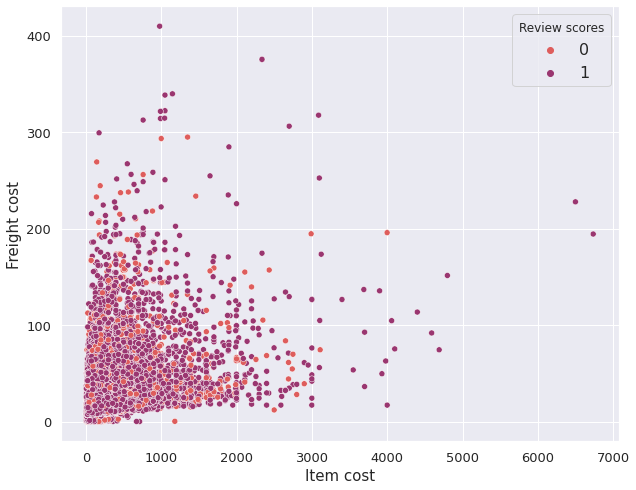

In [44]:
#Reference: https://stackoverflow.com/a/7125157

plt.figure(figsize=(10,8))
sns.scatterplot(x=final_dataframe['price'],y=final_dataframe['freight_value'],hue=final_dataframe['review_score'], palette='flare')
plt.xlabel('Item cost', fontsize=15)
plt.ylabel('Freight cost', fontsize=15)
plt.legend(prop={'size':16}, title='Review scores')
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

**Payment Type Distribution (number of orders):**

Credit cards are the most popular mode of payment among the customers. They are much more popular than the other alternatives. The second in line, Boletos are a type of vouchers which can only be found only in Brazil. From this plot we could see that the bad reviews given to a product were most probably not because of a payment related issue.

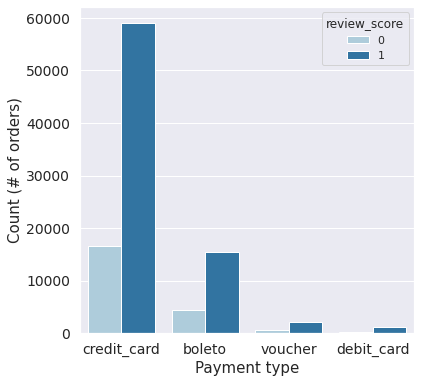

In [45]:
plt.figure(figsize=(6,6))
sns.countplot(data=final_dataframe,x='payment_type', hue='review_score', palette='Paired')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Payment type', fontsize=15)
plt.ylabel('Count (# of orders)', fontsize=15)
plt.show()

**Payment Type Distribution ( order value):**

Credit cards are the most popular mode of payment among the customers with most value.

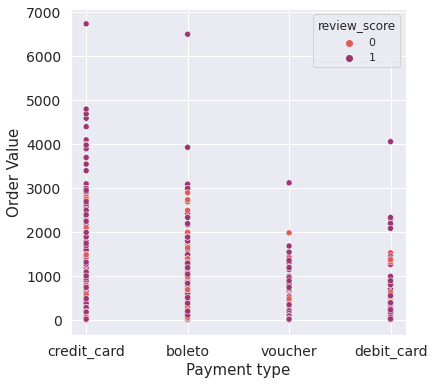

In [46]:
plt.figure(figsize=(6,6))
sns.scatterplot(x=final_dataframe['payment_type'],y=final_dataframe['price'],hue=final_dataframe['review_score'], palette='flare')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Payment type', fontsize=15)
plt.ylabel('Order Value', fontsize=15)
plt.show()

**What is the Orders Average Review Score? By Region/City and product category**

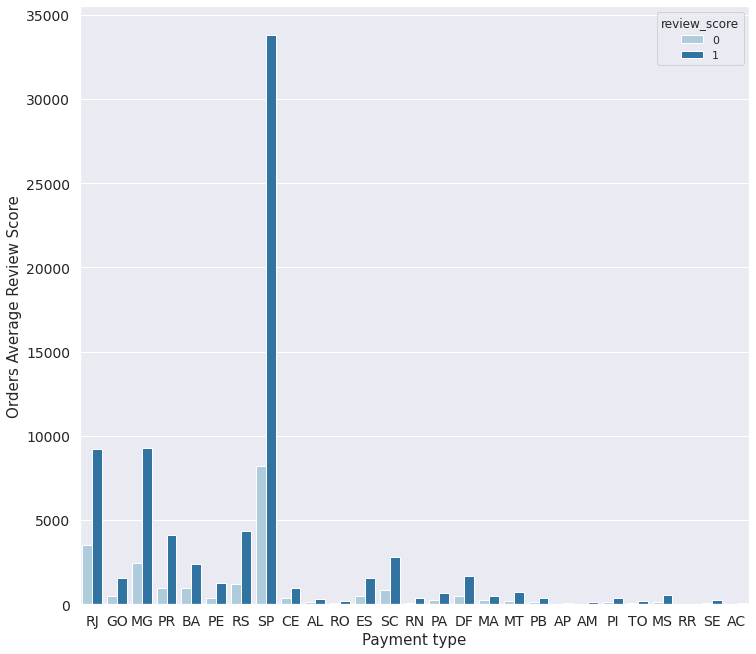

In [51]:
plt.figure(figsize=(12,11))
sns.countplot(data=final_dataframe,x='customer_state', hue='review_score', palette='Paired')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('State', fontsize=15)
plt.ylabel('Orders Average Review Score', fontsize=15)
plt.show()

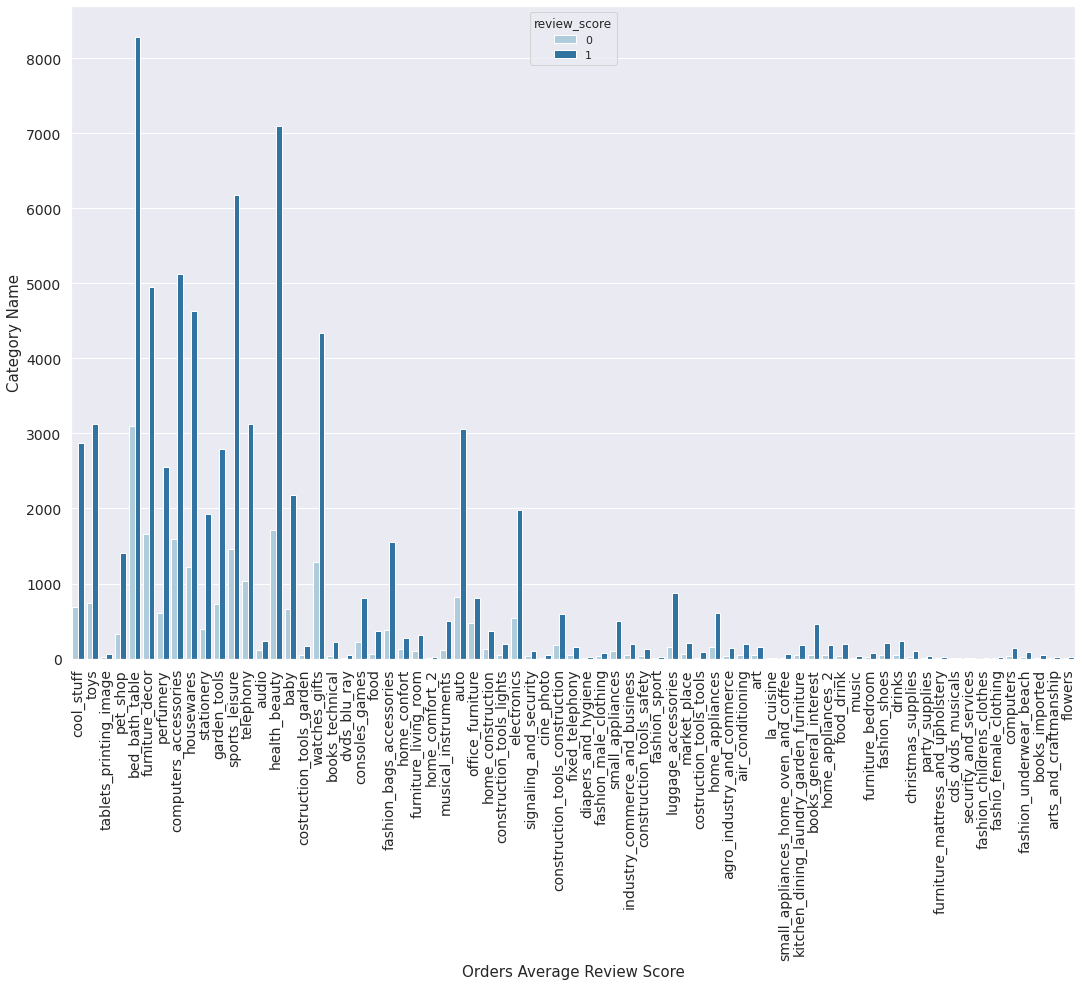

In [63]:
plt.figure(figsize=(18,12))
sns.countplot(data=final_dataframe,x='product_category_name', hue='review_score', palette='Paired')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Orders Average Review Score', fontsize=15)
plt.ylabel('Category Name',fontsize=15)
plt.xticks(rotation=90)
plt.show()



---

